In [1]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import gammapy_fct as gf
import pandas as pd
import numpy as np
from copy import deepcopy
import astropy
import gammapy
from astropy.table import Table, vstack
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.data import DataStore, EventList
from gammapy.irf.effective_area import EffectiveAreaTable2D
from gammapy.irf.energy_dispersion import EnergyDispersion2D
from gammapy.irf.psf_gauss import EnergyDependentMultiGaussPSF
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs, Background2D

gammapy.data.HDUIndexTable.VALID_HDU_CLASS
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore, Observation
from gammapy.datasets import (
    Dataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff,
    SpectrumDatasetOnOff
)
from gammapy.modeling.models import *
from gammapy.modeling.models import FoVBackgroundModel
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom, Map, RegionNDMap
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    ReflectedRegionsFinder,
    FoVBackgroundMaker
    
)
from astropy.io import fits
from gammapy.estimators import *
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.utils.regions import make_region
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line

ModuleNotFoundError: No module named 'pandas'

In [23]:
import sys

!cd ~
!conda env list

# conda environments:
#
base                  *  /Users/cedrickperron/anaconda3
myenv                    /Users/cedrickperron/anaconda3/envs/myenv



In [2]:
#source = "crab_created_in_cluster"
source = "crab_A_weather"
data_store = DataStore.from_dir(f"/Users/cedrickperron/GAMMAPY/{source}")
hdu_table = data_store.hdu_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/hdu-index.fits.gz")


obs_table = data_store.obs_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/obs-index.fits.gz")
# Changing the path to the fits files in the HDU_table
hdu_table.remove_column("FILE_DIR")
hdu_table.add_column(f"/Users/cedrickperron/GAMMAPY/{source}", name="FILE_DIR")

In [3]:
hdu_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_NAME,HDU_NAME,FILE_DIR
int64,bytes6,bytes10,bytes54,bytes20,str43
97312,events,events,97312.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/crab_A_weather
97312,gti,gti,97312.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/crab_A_weather
97312,aeff,aeff_2d,97312.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/crab_A_weather
97312,edisp,edisp_2d,97312.anasum.fits,ENERGY DISPERSION,/Users/cedrickperron/GAMMAPY/crab_A_weather
97312,psf,psf_table,97312.anasum.fits,PSF,/Users/cedrickperron/GAMMAPY/crab_A_weather
97312,bkg,bkg_2d,97312.anasum.fits,BKG,/Users/cedrickperron/GAMMAPY/crab_A_weather
97374,events,events,97374.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/crab_A_weather
97374,gti,gti,97374.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/crab_A_weather
97374,aeff,aeff_2d,97374.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/crab_A_weather


In [4]:
obs_table

OBS_ID,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,N_TELS,TELLIST
,deg,deg,deg,deg,deg,s,s,,s,s,,
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes20
97312,84.17265,22.014683,27.260061,62.73994,103.51672,248.76668,217.77345,0.87541246,502431040.0,502431300.0,4,"T1,T2,T3,T4"
97374,84.38838,22.014275,43.862484,46.137516,90.39276,900.2972,807.27856,0.8966801,502856930.0,502857820.0,4,"T1,T2,T3,T4"
97401,83.63451,21.514473,33.519394,56.480606,98.6108,1800.2872,1594.5498,0.88571966,503031580.0,503033380.0,4,"T1,T2,T3,T4"
97405,83.63215,22.51447,11.515071,78.48493,143.13852,1800.3235,1589.502,0.882898,503038430.0,503040220.0,4,"T1,T2,T3,T4"
97407,84.17265,22.014685,11.9462805,78.05372,216.64021,1800.3319,1568.3962,0.8711706,503042140.0,503043970.0,4,"T1,T2,T3,T4"
97412,84.17265,22.014685,37.925858,52.074142,265.6947,1800.2953,1601.6852,0.88967913,503050200.0,503052000.0,4,"T1,T2,T3,T4"
97414,83.63215,22.51447,51.360497,38.639503,274.71603,1800.2806,1630.6052,0.9057506,503053920.0,503055740.0,4,"T1,T2,T3,T4"
97437,83.63167,22.71447,39.37211,50.62789,267.69492,1500.2408,1340.7301,0.89367664,503136900.0,503138400.0,4,"T1,T2,T3,T4"


In [5]:
zenith_angle = list(obs_table["ZEN_PNT"])

azimuth_angle = list(obs_table["AZ_PNT"])
obs_id_list = list(obs_table["OBS_ID"])




total_obs_id = [[],[],[],[],[],[]]

for ind, zen in enumerate(zenith_angle):
    #print(obs_id_list[ind], zen )
    if (zen >= 0) and (zen < 10):
        total_obs_id[0].append(obs_id_list[ind])
    if (zen >= 10) and (zen < 20):
        total_obs_id[1].append(obs_id_list[ind])
    if (zen >= 20) and (zen < 30):
        total_obs_id[2].append(obs_id_list[ind])
    if (zen >= 30) and (zen < 40):
        total_obs_id[3].append(obs_id_list[ind])
    if (zen >= 40) and (zen < 50):
        total_obs_id[4].append(obs_id_list[ind])
    if (zen >= 50):
        total_obs_id[5].append(obs_id_list[ind])
        
total_obs_id.append(obs_id_list)
total_observations = []
#print(total_obs_id)
name = ['0 to 10', "10 to 20", "20 to 30", "30 to 40", "40 to 50", "50 to 90", "Full"]
for ind, obs_id in enumerate(total_obs_id):
    if len(obs_id) == 0:
        print(name[ind], "has 0 observations")
        total_observations.append([])
    else:
        #print(data_store.get_observations(obs_id))
        total_observations.append(data_store.get_observations(obs_id))
        print(name[ind], f"has {len(obs_id)} observations")
        

    

0 to 10 has 0 observations
10 to 20 has 3 observations
20 to 30 has 2 observations
30 to 40 has 5 observations
40 to 50 has 5 observations
50 to 90 has 3 observations
Full has 18 observations


In [55]:
# Target + On region
target_position = SkyCoord(ra="05h34m30.9s",dec="+22d00m44.5s", frame="icrs")
print(target_position)
on_radius=Angle("0.089 deg")
on_region= CircleSkyRegion(center=target_position,radius=on_radius)

<SkyCoord (ICRS): (ra, dec) in deg
    (83.62875, 22.01236111)>


In [111]:
# Energy Axis
energy_axis = MapAxis.from_energy_bounds(1.0, 17.0, 15, unit="TeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(0.9, 25, 20, unit="TeV", name="energy_true")




(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7ff19e17b2b0>)

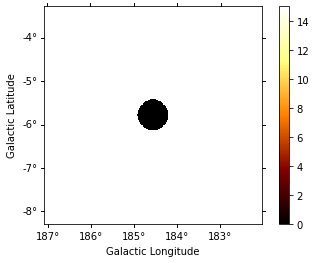

In [112]:
#TODO Take the same exclusion region as Tobias, because you end up with having -600 excess... 
# Exclusion Region 
df=pd.read_csv('./GAMMAPY/exclusion mask.csv', sep=',',header=None)
ra_list = list(df[0])
dec_list = list(df[1])
region_list = []
for ra, dec in zip(ra_list, dec_list):
    region_list.append(make_region(f"icrs;circle({ra}, {dec}, 0.35)"))
exclusion_mask=[]
def exclusion_mask(geom, center_region):
    geom_image = geom
    exclusion_mask=Map.from_geom(geom)
    if center_region not in region_list:
        region_list.append(center_region)
    exclusion_mask.data=geom.region_mask(region_list, inside=False)
    return exclusion_mask

# 0.089
geom = WcsGeom.create(skydir=target_position, binsz=0.02, width="5 deg", frame="galactic", axes=[energy_axis])
center_region = CircleSkyRegion(center=target_position, radius=0.350* u.deg)

exclusion_mask = exclusion_mask(geom, center_region)
exclusion_mask.sum_over_axes().plot(add_cbar=True)

In [135]:
# Dataset Maker
dataset_empty = MapDatasetOnOff.create(geom = geom, energy_axis_true=energy_axis_true, binsz_irf=0.25)

# Contains all the IRFs: aeff is included. No need to specify
dataset_maker = MapDatasetMaker(selection=["counts", "exposure", "edisp", "psf", "background"])
safe_mask_maker = SafeMaskMaker(methods=["aeff-default", "offset-max"], offset_max=1.75*u.deg, aeff_percent=10)

bkg_maker = FoVBackgroundMaker(method="scale", exclusion_mask=exclusion_mask)


In [136]:
%%time
list_of_datasets = []
list_of_stacked = []
count = 0


for ind, observations in enumerate(total_observations):
    stacked = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true,binsz_irf=0.25, name=f"stacked_{name[ind]}")
    
    datasets = Datasets()
    for obs in observations:
        dataset = dataset_maker.run(dataset_empty.copy(name = f"{obs.obs_id}_{name[ind]}"), obs)
        dataset = safe_mask_maker.run(dataset, obs)
        dataset = bkg_maker.run(dataset, obs)
        stacked.stack(dataset)
        dataset = dataset.to_spectrum_dataset(on_region=on_region, containment_correction=True,name=dataset.name)
        #dataset.background = dataset.background * exclusion_mask
        print(dataset)
        print(count, dataset)
        count += 1
        datasets.append(dataset)
    list_of_datasets.append(datasets)
    if (len(observations) != 0):
        stacked = stacked.to_spectrum_dataset(on_region=on_region, containment_correction=True,name=dataset.name)
        list_of_stacked.append(stacked)
    else:
        list_of_stacked.append(None)
    print()
    
complete_datasets = list_of_datasets[-1]
list_of_datasets = list_of_datasets[:-1]
complete_stacked = list_of_stacked[-1]
list_of_stacked = list_of_stacked[:-1]
print(len(list_of_datasets))
    
    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97405_10 to 20 

  Total counts                    : 38 
  Total background counts         : 0.29
  Total excess counts             : 37.71

  Predicted counts                : 0.29
  Predicted background counts     : 0.29
  Predicted excess counts         : nan

  Exposure min                    : 4.38e+07 m2 s
  Exposure max                    : 3.13e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


0 SpectrumDataset
---------------

  Name                            : 97405_10 to 20 

  Total counts                    : 38 
  Total background counts         : 0.29
  Total excess counts             : 37.71

  Predicted counts                : 0.29
  Predicted background counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97407_10 to 20 

  Total counts                    : 24 
  Total background counts         : 0.23
  Total excess counts             : 23.77

  Predicted counts                : 0.23
  Predicted background counts     : 0.23
  Predicted excess counts         : nan

  Exposure min                    : 4.27e+07 m2 s
  Exposure max                    : 3.08e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


1 SpectrumDataset
---------------

  Name                            : 97407_10 to 20 

  Total counts                    : 24 
  Total background counts         : 0.23
  Total excess counts             : 23.77

  Predicted counts                : 0.23
  Predicted background counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97406_10 to 20 

  Total counts                    : 44 
  Total background counts         : 0.29
  Total excess counts             : 43.71

  Predicted counts                : 0.29
  Predicted background counts     : 0.29
  Predicted excess counts         : nan

  Exposure min                    : 4.34e+07 m2 s
  Exposure max                    : 3.31e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


2 SpectrumDataset
---------------

  Name                            : 97406_10 to 20 

  Total counts                    : 44 
  Total background counts         : 0.29
  Total excess counts             : 43.71

  Predicted counts                : 0.29
  Predicted background counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97312_20 to 30 

  Total counts                    : 7 
  Total background counts         : 0.05
  Total excess counts             : 6.95

  Predicted counts                : 0.05
  Predicted background counts     : 0.05
  Predicted excess counts         : nan

  Exposure min                    : 7.12e+06 m2 s
  Exposure max                    : 3.56e+07 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


3 SpectrumDataset
---------------

  Name                            : 97312_20 to 30 

  Total counts                    : 7 
  Total background counts         : 0.05
  Total excess counts             : 6.95

  Predicted counts                : 0.05
  Predicted background counts     : 0

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97403_20 to 30 

  Total counts                    : 30 
  Total background counts         : 0.44
  Total excess counts             : 29.56

  Predicted counts                : 0.44
  Predicted background counts     : 0.44
  Predicted excess counts         : nan

  Exposure min                    : 3.60e+07 m2 s
  Exposure max                    : 2.14e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


4 SpectrumDataset
---------------

  Name                            : 97403_20 to 30 

  Total counts                    : 30 
  Total background counts         : 0.44
  Total excess counts             : 29.56

  Predicted counts                : 0.44
  Predicted background counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97401_30 to 40 

  Total counts                    : 45 
  Total background counts         : 0.50
  Total excess counts             : 44.50

  Predicted counts                : 0.50
  Predicted background counts     : 0.50
  Predicted excess counts         : nan

  Exposure min                    : 1.37e+08 m2 s
  Exposure max                    : 5.28e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


5 SpectrumDataset
---------------

  Name                            : 97401_30 to 40 

  Total counts                    : 45 
  Total background counts         : 0.50
  Total excess counts             : 44.50

  Predicted counts                : 0.50
  Predicted background counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97412_30 to 40 

  Total counts                    : 48 
  Total background counts         : 0.62
  Total excess counts             : 47.38

  Predicted counts                : 0.62
  Predicted background counts     : 0.62
  Predicted excess counts         : nan

  Exposure min                    : 1.51e+08 m2 s
  Exposure max                    : 6.60e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


6 SpectrumDataset
---------------

  Name                            : 97412_30 to 40 

  Total counts                    : 48 
  Total background counts         : 0.62
  Total excess counts             : 47.38

  Predicted counts                : 0.62
  Predicted background counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97437_30 to 40 

  Total counts                    : 36 
  Total background counts         : 0.57
  Total excess counts             : 35.43

  Predicted counts                : 0.57
  Predicted background counts     : 0.57
  Predicted excess counts         : nan

  Exposure min                    : 1.00e+08 m2 s
  Exposure max                    : 3.48e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


7 SpectrumDataset
---------------

  Name                            : 97437_30 to 40 

  Total counts                    : 36 
  Total background counts         : 0.57
  Total excess counts             : 35.43

  Predicted counts                : 0.57
  Predicted background counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97400_30 to 40 

  Total counts                    : 54 
  Total background counts         : 0.99
  Total excess counts             : 53.01

  Predicted counts                : 0.99
  Predicted background counts     : 0.99
  Predicted excess counts         : nan

  Exposure min                    : 1.30e+08 m2 s
  Exposure max                    : 4.13e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


8 SpectrumDataset
---------------

  Name                            : 97400_30 to 40 

  Total counts                    : 54 
  Total background counts         : 0.99
  Total excess counts             : 53.01

  Predicted counts                : 0.99
  Predicted background counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97411_30 to 40 

  Total counts                    : 44 
  Total background counts         : 0.44
  Total excess counts             : 43.56

  Predicted counts                : 0.44
  Predicted background counts     : 0.44
  Predicted excess counts         : nan

  Exposure min                    : 6.58e+07 m2 s
  Exposure max                    : 3.75e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


9 SpectrumDataset
---------------

  Name                            : 97411_30 to 40 

  Total counts                    : 44 
  Total background counts         : 0.44
  Total excess counts             : 43.56

  Predicted counts                : 0.44
  Predicted background counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97374_40 to 50 

  Total counts                    : 25 
  Total background counts         : 0.89
  Total excess counts             : 24.11

  Predicted counts                : 0.89
  Predicted background counts     : 0.89
  Predicted excess counts         : nan

  Exposure min                    : 6.54e+07 m2 s
  Exposure max                    : 2.11e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


10 SpectrumDataset
---------------

  Name                            : 97374_40 to 50 

  Total counts                    : 25 
  Total background counts         : 0.89
  Total excess counts             : 24.11

  Predicted counts                : 0.89
  Predicted background counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97316_40 to 50 

  Total counts                    : 24 
  Total background counts         : 0.58
  Total excess counts             : 23.42

  Predicted counts                : 0.58
  Predicted background counts     : 0.58
  Predicted excess counts         : nan

  Exposure min                    : 7.01e+07 m2 s
  Exposure max                    : 2.21e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


11 SpectrumDataset
---------------

  Name                            : 97316_40 to 50 

  Total counts                    : 24 
  Total background counts         : 0.58
  Total excess counts             : 23.42

  Predicted counts                : 0.58
  Predicted background counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97413_40 to 50 

  Total counts                    : 49 
  Total background counts         : 1.45
  Total excess counts             : 47.55

  Predicted counts                : 1.45
  Predicted background counts     : 1.45
  Predicted excess counts         : nan

  Exposure min                    : 1.75e+08 m2 s
  Exposure max                    : 6.52e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


12 SpectrumDataset
---------------

  Name                            : 97413_40 to 50 

  Total counts                    : 49 
  Total background counts         : 1.45
  Total excess counts             : 47.55

  Predicted counts                : 1.45
  Predicted background counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97438_40 to 50 

  Total counts                    : 13 
  Total background counts         : 0.49
  Total excess counts             : 12.51

  Predicted counts                : 0.49
  Predicted background counts     : 0.49
  Predicted excess counts         : nan

  Exposure min                    : 5.50e+07 m2 s
  Exposure max                    : 2.02e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


13 SpectrumDataset
---------------

  Name                            : 97438_40 to 50 

  Total counts                    : 13 
  Total background counts         : 0.49
  Total excess counts             : 12.51

  Predicted counts                : 0.49
  Predicted background counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97487_40 to 50 

  Total counts                    : 39 
  Total background counts         : 0.84
  Total excess counts             : 38.16

  Predicted counts                : 0.84
  Predicted background counts     : 0.84
  Predicted excess counts         : nan

  Exposure min                    : 9.09e+07 m2 s
  Exposure max                    : 3.31e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


14 SpectrumDataset
---------------

  Name                            : 97487_40 to 50 

  Total counts                    : 39 
  Total background counts         : 0.84
  Total excess counts             : 38.16

  Predicted counts                : 0.84
  Predicted background counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97414_50 to 90 

  Total counts                    : 57 
  Total background counts         : 2.27
  Total excess counts             : 54.73

  Predicted counts                : 2.27
  Predicted background counts     : 2.27
  Predicted excess counts         : nan

  Exposure min                    : 1.00e+08 m2 s
  Exposure max                    : 3.13e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


15 SpectrumDataset
---------------

  Name                            : 97414_50 to 90 

  Total counts                    : 57 
  Total background counts         : 2.27
  Total excess counts             : 54.73

  Predicted counts                : 2.27
  Predicted background counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97440_50 to 90 

  Total counts                    : 0 
  Total background counts         : 0.28
  Total excess counts             : -0.28

  Predicted counts                : 0.28
  Predicted background counts     : 0.28
  Predicted excess counts         : nan

  Exposure min                    : 5.04e+06 m2 s
  Exposure max                    : 1.63e+07 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


16 SpectrumDataset
---------------

  Name                            : 97440_50 to 90 

  Total counts                    : 0 
  Total background counts         : 0.28
  Total excess counts             : -0.28

  Predicted counts                : 0.28
  Predicted background counts     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97415_50 to 90 

  Total counts                    : 40 
  Total background counts         : 3.54
  Total excess counts             : 36.46

  Predicted counts                : 3.54
  Predicted background counts     : 3.54
  Predicted excess counts         : nan

  Exposure min                    : 1.05e+08 m2 s
  Exposure max                    : 3.22e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


17 SpectrumDataset
---------------

  Name                            : 97415_50 to 90 

  Total counts                    : 40 
  Total background counts         : 3.54
  Total excess counts             : 36.46

  Predicted counts                : 3.54
  Predicted background counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97312_Full 

  Total counts                    : 7 
  Total background counts         : 0.05
  Total excess counts             : 6.95

  Predicted counts                : 0.05
  Predicted background counts     : 0.05
  Predicted excess counts         : nan

  Exposure min                    : 7.12e+06 m2 s
  Exposure max                    : 3.56e+07 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


18 SpectrumDataset
---------------

  Name                            : 97312_Full 

  Total counts                    : 7 
  Total background counts         : 0.05
  Total excess counts             : 6.95

  Predicted counts                : 0.05
  Predicted background counts     : 0.05
  P

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97374_Full 

  Total counts                    : 25 
  Total background counts         : 0.89
  Total excess counts             : 24.11

  Predicted counts                : 0.89
  Predicted background counts     : 0.89
  Predicted excess counts         : nan

  Exposure min                    : 6.54e+07 m2 s
  Exposure max                    : 2.11e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


19 SpectrumDataset
---------------

  Name                            : 97374_Full 

  Total counts                    : 25 
  Total background counts         : 0.89
  Total excess counts             : 24.11

  Predicted counts                : 0.89
  Predicted background counts     : 0.89

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97401_Full 

  Total counts                    : 45 
  Total background counts         : 0.50
  Total excess counts             : 44.50

  Predicted counts                : 0.50
  Predicted background counts     : 0.50
  Predicted excess counts         : nan

  Exposure min                    : 1.37e+08 m2 s
  Exposure max                    : 5.28e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


20 SpectrumDataset
---------------

  Name                            : 97401_Full 

  Total counts                    : 45 
  Total background counts         : 0.50
  Total excess counts             : 44.50

  Predicted counts                : 0.50
  Predicted background counts     : 0.50

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97405_Full 

  Total counts                    : 38 
  Total background counts         : 0.29
  Total excess counts             : 37.71

  Predicted counts                : 0.29
  Predicted background counts     : 0.29
  Predicted excess counts         : nan

  Exposure min                    : 4.38e+07 m2 s
  Exposure max                    : 3.13e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


21 SpectrumDataset
---------------

  Name                            : 97405_Full 

  Total counts                    : 38 
  Total background counts         : 0.29
  Total excess counts             : 37.71

  Predicted counts                : 0.29
  Predicted background counts     : 0.29

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97407_Full 

  Total counts                    : 24 
  Total background counts         : 0.23
  Total excess counts             : 23.77

  Predicted counts                : 0.23
  Predicted background counts     : 0.23
  Predicted excess counts         : nan

  Exposure min                    : 4.27e+07 m2 s
  Exposure max                    : 3.08e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


22 SpectrumDataset
---------------

  Name                            : 97407_Full 

  Total counts                    : 24 
  Total background counts         : 0.23
  Total excess counts             : 23.77

  Predicted counts                : 0.23
  Predicted background counts     : 0.23

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97412_Full 

  Total counts                    : 48 
  Total background counts         : 0.62
  Total excess counts             : 47.38

  Predicted counts                : 0.62
  Predicted background counts     : 0.62
  Predicted excess counts         : nan

  Exposure min                    : 1.51e+08 m2 s
  Exposure max                    : 6.60e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


23 SpectrumDataset
---------------

  Name                            : 97412_Full 

  Total counts                    : 48 
  Total background counts         : 0.62
  Total excess counts             : 47.38

  Predicted counts                : 0.62
  Predicted background counts     : 0.62

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97414_Full 

  Total counts                    : 57 
  Total background counts         : 2.27
  Total excess counts             : 54.73

  Predicted counts                : 2.27
  Predicted background counts     : 2.27
  Predicted excess counts         : nan

  Exposure min                    : 1.00e+08 m2 s
  Exposure max                    : 3.13e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


24 SpectrumDataset
---------------

  Name                            : 97414_Full 

  Total counts                    : 57 
  Total background counts         : 2.27
  Total excess counts             : 54.73

  Predicted counts                : 2.27
  Predicted background counts     : 2.27

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97437_Full 

  Total counts                    : 36 
  Total background counts         : 0.57
  Total excess counts             : 35.43

  Predicted counts                : 0.57
  Predicted background counts     : 0.57
  Predicted excess counts         : nan

  Exposure min                    : 1.00e+08 m2 s
  Exposure max                    : 3.48e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


25 SpectrumDataset
---------------

  Name                            : 97437_Full 

  Total counts                    : 36 
  Total background counts         : 0.57
  Total excess counts             : 35.43

  Predicted counts                : 0.57
  Predicted background counts     : 0.57

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97440_Full 

  Total counts                    : 0 
  Total background counts         : 0.28
  Total excess counts             : -0.28

  Predicted counts                : 0.28
  Predicted background counts     : 0.28
  Predicted excess counts         : nan

  Exposure min                    : 5.04e+06 m2 s
  Exposure max                    : 1.63e+07 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


26 SpectrumDataset
---------------

  Name                            : 97440_Full 

  Total counts                    : 0 
  Total background counts         : 0.28
  Total excess counts             : -0.28

  Predicted counts                : 0.28
  Predicted background counts     : 0.28
 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97316_Full 

  Total counts                    : 24 
  Total background counts         : 0.58
  Total excess counts             : 23.42

  Predicted counts                : 0.58
  Predicted background counts     : 0.58
  Predicted excess counts         : nan

  Exposure min                    : 7.01e+07 m2 s
  Exposure max                    : 2.21e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


27 SpectrumDataset
---------------

  Name                            : 97316_Full 

  Total counts                    : 24 
  Total background counts         : 0.58
  Total excess counts             : 23.42

  Predicted counts                : 0.58
  Predicted background counts     : 0.58

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97400_Full 

  Total counts                    : 54 
  Total background counts         : 0.99
  Total excess counts             : 53.01

  Predicted counts                : 0.99
  Predicted background counts     : 0.99
  Predicted excess counts         : nan

  Exposure min                    : 1.30e+08 m2 s
  Exposure max                    : 4.13e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


28 SpectrumDataset
---------------

  Name                            : 97400_Full 

  Total counts                    : 54 
  Total background counts         : 0.99
  Total excess counts             : 53.01

  Predicted counts                : 0.99
  Predicted background counts     : 0.99

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97403_Full 

  Total counts                    : 30 
  Total background counts         : 0.44
  Total excess counts             : 29.56

  Predicted counts                : 0.44
  Predicted background counts     : 0.44
  Predicted excess counts         : nan

  Exposure min                    : 3.60e+07 m2 s
  Exposure max                    : 2.14e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


29 SpectrumDataset
---------------

  Name                            : 97403_Full 

  Total counts                    : 30 
  Total background counts         : 0.44
  Total excess counts             : 29.56

  Predicted counts                : 0.44
  Predicted background counts     : 0.44

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97406_Full 

  Total counts                    : 44 
  Total background counts         : 0.29
  Total excess counts             : 43.71

  Predicted counts                : 0.29
  Predicted background counts     : 0.29
  Predicted excess counts         : nan

  Exposure min                    : 4.34e+07 m2 s
  Exposure max                    : 3.31e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


30 SpectrumDataset
---------------

  Name                            : 97406_Full 

  Total counts                    : 44 
  Total background counts         : 0.29
  Total excess counts             : 43.71

  Predicted counts                : 0.29
  Predicted background counts     : 0.29

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97411_Full 

  Total counts                    : 44 
  Total background counts         : 0.44
  Total excess counts             : 43.56

  Predicted counts                : 0.44
  Predicted background counts     : 0.44
  Predicted excess counts         : nan

  Exposure min                    : 6.58e+07 m2 s
  Exposure max                    : 3.75e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


31 SpectrumDataset
---------------

  Name                            : 97411_Full 

  Total counts                    : 44 
  Total background counts         : 0.44
  Total excess counts             : 43.56

  Predicted counts                : 0.44
  Predicted background counts     : 0.44

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97413_Full 

  Total counts                    : 49 
  Total background counts         : 1.45
  Total excess counts             : 47.55

  Predicted counts                : 1.45
  Predicted background counts     : 1.45
  Predicted excess counts         : nan

  Exposure min                    : 1.75e+08 m2 s
  Exposure max                    : 6.52e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


32 SpectrumDataset
---------------

  Name                            : 97413_Full 

  Total counts                    : 49 
  Total background counts         : 1.45
  Total excess counts             : 47.55

  Predicted counts                : 1.45
  Predicted background counts     : 1.45

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97415_Full 

  Total counts                    : 40 
  Total background counts         : 3.54
  Total excess counts             : 36.46

  Predicted counts                : 3.54
  Predicted background counts     : 3.54
  Predicted excess counts         : nan

  Exposure min                    : 1.05e+08 m2 s
  Exposure max                    : 3.22e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


33 SpectrumDataset
---------------

  Name                            : 97415_Full 

  Total counts                    : 40 
  Total background counts         : 3.54
  Total excess counts             : 36.46

  Predicted counts                : 3.54
  Predicted background counts     : 3.54

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97438_Full 

  Total counts                    : 13 
  Total background counts         : 0.49
  Total excess counts             : 12.51

  Predicted counts                : 0.49
  Predicted background counts     : 0.49
  Predicted excess counts         : nan

  Exposure min                    : 5.50e+07 m2 s
  Exposure max                    : 2.02e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


34 SpectrumDataset
---------------

  Name                            : 97438_Full 

  Total counts                    : 13 
  Total background counts         : 0.49
  Total excess counts             : 12.51

  Predicted counts                : 0.49
  Predicted background counts     : 0.49

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SpectrumDataset
---------------

  Name                            : 97487_Full 

  Total counts                    : 39 
  Total background counts         : 0.84
  Total excess counts             : 38.16

  Predicted counts                : 0.84
  Predicted background counts     : 0.84
  Predicted excess counts         : nan

  Exposure min                    : 9.09e+07 m2 s
  Exposure max                    : 3.31e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


35 SpectrumDataset
---------------

  Name                            : 97487_Full 

  Total counts                    : 39 
  Total background counts         : 0.84
  Total excess counts             : 38.16

  Predicted counts                : 0.84
  Predicted background counts     : 0.84

In [115]:
stacked = complete_stacked
d = Datasets(stacked).info_table()

count = d["counts"][0]
excess_rate = []
count_rate = []
bkg_rate = []
bkg_count = d["background"][0]
exc_count = d['excess'][0]
on_time = d["ontime"][0]
excess_rate.append(exc_count/on_time)
count_rate.append(count/on_time)
bkg_rate.append(bkg_count/on_time)
d["counts_rate"] = count_rate* 1/u.s
d["excess_rate"] = excess_rate* 1/u.s
d["background_rate"] = bkg_rate * 1/u.s
d["ontime"] = d["ontime"]/3600
d["counts","background","excess", "sqrt_ts", "ontime", "counts_rate", 'background_rate',"excess_rate"]

counts,background,excess,sqrt_ts,ontime,counts_rate,background_rate,excess_rate
,,,,s,1 / s,1 / s,1 / s
float32,float32,float32,float64,float64,float64,float64,float64
617.0,14.768767,602.23126,58.32034847832422,7.101420818401707,0.02413445045317886,0.0005776921945364118,0.023556759415058286


In [72]:
print(len(list_of_datasets))

6


In [73]:
%%cache
#index 0

index = 0

print(name[index])
a = list_of_datasets[index].info_table(cumulative=False)



zen_col = []
az_col = []
for ind, obs_id in enumerate(obs_id_list):
    if obs_id in total_obs_id[index]:
        zen_col.append(list(obs_table["ZEN_PNT"])[ind])
        az_col.append(list(obs_table["AZ_PNT"])[ind])
from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate

fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()

a

UsageError: Cell magic `%%cache` not found.


10 to 20


name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,Zenith,Azimuth
,,,,,,,,m2 s,m2 s,s,s,,,,,,,,,
str14,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64,float32,float32
97405_10 to 20,2431.0,1329.674296501318,1101.325703498682,27.035657999369555,2104.756879544658,2104.756879544658,0.0,358.4834492082958,240792051.46705577,nan,1800.3234959840775,1.3503128773371853,0.7385752057712843,0.6117376715659009,600000,353940,cash,26895.224675146554,11.515071,143.13852
97407_10 to 20,2134.0,1329.230519058372,804.769480941628,20.27124379822237,1792.823444962128,1792.823444962128,0.0,0.048798953186702215,239659949.70266044,nan,1800.3319681882858,1.1853369476894262,0.7383252325380892,0.44701171515133703,600000,353790,cash,24050.24545423856,11.9462805,216.64021
97406_10 to 20,2278.0,1376.176202701899,901.823797298101,22.192976696651975,1903.4752191515076,1903.4752191515076,0.0,0.027297054964411014,234862233.82154286,nan,1800.3130071163177,1.265335522764914,0.7644094095094124,0.5009261132555015,600000,353925,cash,30812.912212061594,10.27231,181.60292


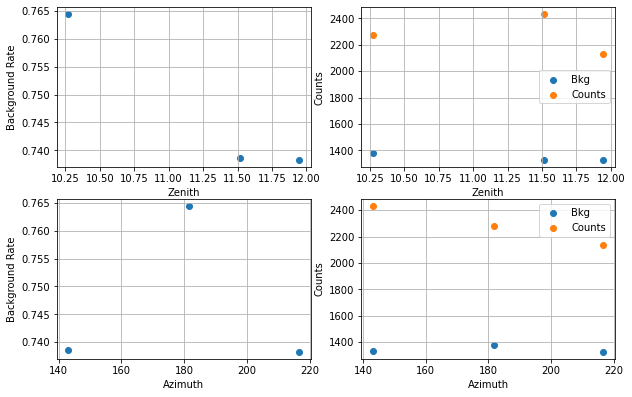

In [14]:
#index 1

index = 1

print(name[index])
a = list_of_datasets[index].info_table(cumulative=False)



zen_col = []
az_col = []
for ind, obs_id in enumerate(obs_id_list):
    if obs_id in total_obs_id[index]:
        zen_col.append(list(obs_table["ZEN_PNT"])[ind])
        az_col.append(list(obs_table["AZ_PNT"])[ind])
from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate

fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()

a

20 to 30


name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,Zenith,Azimuth
,,,,,,,,m2 s,m2 s,s,s,,,,,,,,,
str14,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64,float32,float32
97312_20 to 30,252.0,225.60303033228448,26.396969667715524,1.7247470304192043,203.73807453272568,203.73807453272568,0.0,0.43304549624481353,38617515.399506435,nan,248.76667392253876,1.0129974245604458,0.9068860662683982,0.10611135829204776,600000,353790,cash,3764.850627413303,27.260061,103.51672
97403_20 to 30,2452.0,1376.9153251381397,1075.0846748618603,26.071557397799992,2152.9284116734225,2152.9284116734225,0.0,0.43383495624997837,256004808.15243807,nan,1800.3286049365997,1.361973582642903,0.7648133353891964,0.5971602472537064,600000,354195,cash,31500.346169641096,20.479954,113.507996


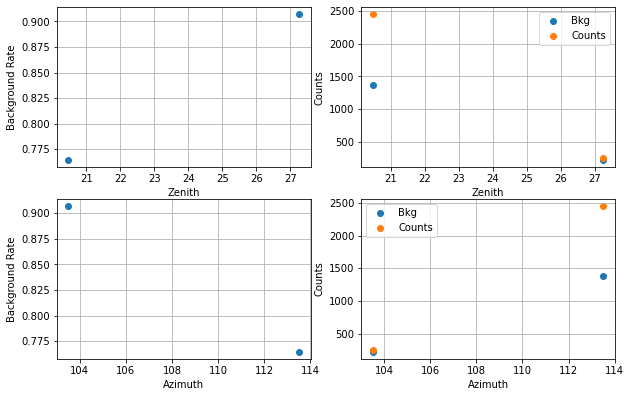

In [15]:
#index 2

index = 2

print(name[index])
a = list_of_datasets[index].info_table(cumulative=False)



zen_col = []
az_col = []
for ind, obs_id in enumerate(obs_id_list):
    if obs_id in total_obs_id[index]:
        zen_col.append(list(obs_table["ZEN_PNT"])[ind])
        az_col.append(list(obs_table["AZ_PNT"])[ind])
from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate

fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()

a

30 to 40


name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,Zenith,Azimuth
,,,,,,,,m2 s,m2 s,s,s,,,,,,,,,
str14,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64,float32,float32
97401_30 to 40,1615.0,1376.1565212241253,238.8434787758747,6.264430499795237,1322.325705339764,1322.325705339764,0.0,0.26017158603146245,327853618.2711288,nan,1800.2872598171234,0.8970790584631781,0.7644094095094124,0.1326696489537658,600000,353925,cash,18226.930428253283,33.519394,98.6108
97412_30 to 40,1419.0,1632.662682709415,-213.6626827094151,-5.410043970577401,1172.8134769558083,1172.8134769558083,0.0,0.018440991377874295,401444491.22205424,nan,1800.2952900528908,0.7882040284393075,0.9068860490444594,-0.1186820206051519,600000,353790,cash,17252.630911593038,37.925858,265.6947
97437_30 to 40,1163.0,1577.5778620333354,-414.57786203333535,-10.953863103664668,995.9477093099068,995.9477093099068,0.0,0.011949412976256691,342622492.9989715,nan,1500.2407945394516,0.77520888928835,1.0515497697272156,-0.2763408804388656,600000,338565,cash,15545.21049346358,39.37211,267.69492
97400_30 to 40,1687.0,1329.6337431386341,357.36625686136586,9.404348239199308,1452.356024042334,1452.356024042334,0.0,3.804780094715824e-05,389014694.34101576,nan,1800.268588423729,0.9370823947314971,0.7385752057712838,0.19850718896021344,600000,353940,cash,18894.831803622114,39.97551,92.18513
97411_30 to 40,1682.0,1376.1618177107787,305.8381822892213,7.964131790356729,1368.6492173102652,1368.6492173102652,0.0,0.7615614956377099,319630400.67459273,nan,1800.2941886782646,0.9342917455257057,0.7644094095094123,0.16988233601629343,600000,353925,cash,20194.69184039914,30.034603,258.2285


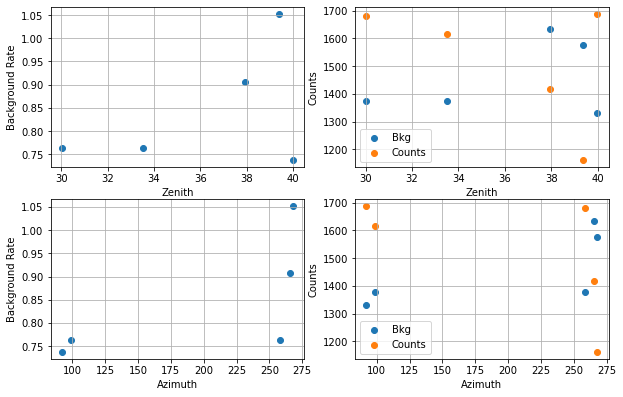

In [16]:
#index 3

index = 3

print(name[index])
a = list_of_datasets[index].info_table(cumulative=False)



zen_col = []
az_col = []
for ind, obs_id in enumerate(obs_id_list):
    if obs_id in total_obs_id[index]:
        zen_col.append(list(obs_table["ZEN_PNT"])[ind])
        az_col.append(list(obs_table["AZ_PNT"])[ind])
from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate

fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")

plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()

a

40 to 50


name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,Zenith,Azimuth
,,,,,,,,m2 s,m2 s,s,s,,,,,,,,,
str14,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64,float32,float32
97374_40 to 50,838.0,666.3672388795675,171.63276112043252,6.390274279522944,751.2390235050825,751.2390235050825,0.0,0.037702549112174015,232786585.3792327,nan,900.2971748709679,0.9308037650124844,0.7401636453819511,0.19064011963053334,600000,338355,cash,10153.879873384778,43.862484,90.39276
97316_40 to 50,966.0,667.0590575387704,298.9409424612296,10.840149406857977,850.5561202910278,850.5561202910278,0.0,0.01936588151761849,206156238.1307624,nan,903.2027333974838,1.069527321254109,0.7385485371922688,0.33097878406184017,600000,353925,cash,11867.29338836444,41.061832,92.967384
97413_40 to 50,1598.0,1330.2919570127037,267.70804298729627,7.1123102867774,1403.8506942354677,1403.8506942354677,0.0,1167.4014572040005,519144436.83893406,nan,1800.2781456708908,0.8876406147809399,0.7389369027289713,0.14870371205196867,600000,354195,cash,18775.218238090874,45.207508,270.4436
97438_40 to 50,625.0,548.0247148777768,76.97528512222323,3.2154142144674007,541.5361311354719,541.5361311354719,0.0,0.0003670658047804428,204287656.2272509,nan,739.5336358547211,0.8451272122026633,0.7410409592045039,0.10408625299815946,600000,338895,cash,7899.1069280945785,44.00025,268.71747
97487_40 to 50,1151.0,955.5855416728166,195.4144583271834,6.122607363357701,1001.9732569864427,1001.9732569864427,0.0,0.0014558146780597806,340506137.84434605,nan,1290.3081592321396,0.8920349699136665,0.7405870720382672,0.1514478978753992,600000,338565,cash,13114.712067038294,43.09932,270.14764


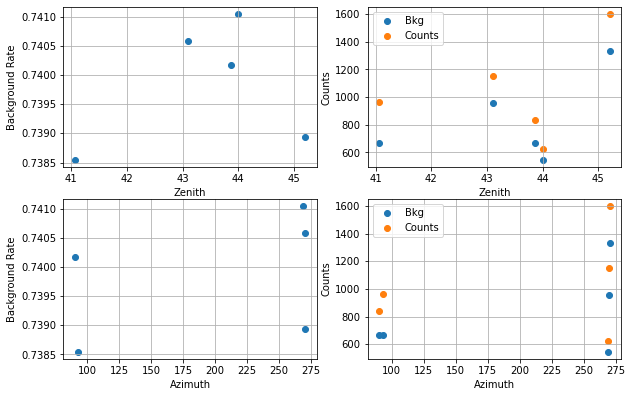

In [17]:
#index 4

index = 4

print(name[index])
a = list_of_datasets[index].info_table(cumulative=False)



zen_col = []
az_col = []
for ind, obs_id in enumerate(obs_id_list):
    if obs_id in total_obs_id[index]:
        zen_col.append(list(obs_table["ZEN_PNT"])[ind])
        az_col.append(list(obs_table["AZ_PNT"])[ind])
from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate



fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()


a

50 to 90


name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,Zenith,Azimuth
,,,,,,,,m2 s,m2 s,s,s,,,,,,,,,
str14,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64,float32,float32
97414_50 to 90,1667.0,1949.3046732452067,-282.3046732452067,-6.558506263945314,1526.8011638824896,1526.8011638824896,0.0,1.4878797836236868,592159627.3444582,nan,1800.2806250452995,0.9259667502993063,1.082778232530363,-0.15681148223105673,600000,353940,cash,24854.84802956687,51.360497,274.71603
97440_50 to 90,152.0,175.02861581740186,-23.028615817401857,-1.7810764772303296,141.39387067316366,141.39387067316366,0.0,0.0017973703266369887,59744229.17594749,nan,179.47535985708237,0.8469129139567615,0.975223651629831,-0.12831073767306958,600000,306450,cash,2930.6440892821875,53.721447,274.0269
97415_50 to 90,1930.0,1376.1580353977463,553.8419646022537,14.066365182577869,1827.6731086543243,1827.6731086543243,0.0,0.4204242880970381,600800894.8938519,nan,1800.2892406582832,1.0720499553140068,0.7644094095094122,0.30764054580459477,600000,353925,cash,21528.626829657333,58.287357,277.2382


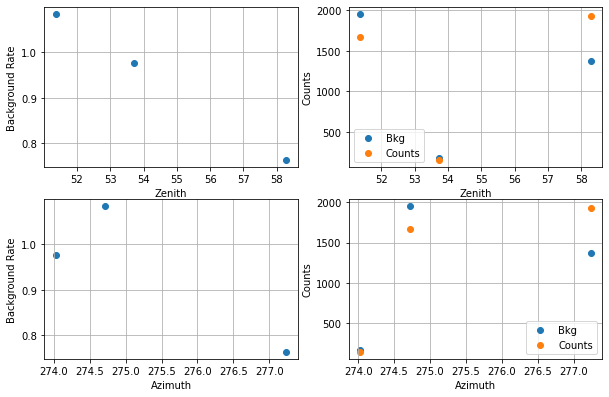

In [18]:

#index 5

index = 5

print(name[index])
a = list_of_datasets[index].info_table(cumulative=False)



zen_col = []
az_col = []
for ind, obs_id in enumerate(obs_id_list):
    if obs_id in total_obs_id[index]:
        zen_col.append(list(obs_table["ZEN_PNT"])[ind])
        az_col.append(list(obs_table["AZ_PNT"])[ind])
from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate

fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()

a

Full


name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,Zenith,Azimuth
,,,,,,,,m2 s,m2 s,s,s,,,,,,,,,
str10,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64,float32,float32
97312_Full,252.0,225.60303033228448,26.396969667715524,1.7247470304192043,203.73807453272568,203.73807453272568,0.0,0.43304549624481353,38617515.399506435,nan,248.76667392253876,1.0129974245604458,0.9068860662683982,0.10611135829204776,600000,353790,cash,3764.850627413303,27.260061,103.51672
97374_Full,838.0,666.3672388795675,171.63276112043252,6.390274279522944,751.2390235050825,751.2390235050825,0.0,0.037702549112174015,232786585.3792327,nan,900.2971748709679,0.9308037650124844,0.7401636453819511,0.19064011963053334,600000,338355,cash,10153.879873384778,43.862484,90.39276
97401_Full,1615.0,1376.1565212241253,238.8434787758747,6.264430499795237,1322.325705339764,1322.325705339764,0.0,0.26017158603146245,327853618.2711288,nan,1800.2872598171234,0.8970790584631781,0.7644094095094124,0.1326696489537658,600000,353925,cash,18226.930428253283,33.519394,98.6108
97405_Full,2431.0,1329.674296501318,1101.325703498682,27.035657999369555,2104.756879544658,2104.756879544658,0.0,358.4834492082958,240792051.46705577,nan,1800.3234959840775,1.3503128773371853,0.7385752057712843,0.6117376715659009,600000,353940,cash,26895.224675146554,11.515071,143.13852
97407_Full,2134.0,1329.230519058372,804.769480941628,20.27124379822237,1792.823444962128,1792.823444962128,0.0,0.048798953186702215,239659949.70266044,nan,1800.3319681882858,1.1853369476894262,0.7383252325380892,0.44701171515133703,600000,353790,cash,24050.24545423856,11.9462805,216.64021
97412_Full,1419.0,1632.662682709415,-213.6626827094151,-5.410043970577401,1172.8134769558083,1172.8134769558083,0.0,0.018440991377874295,401444491.22205424,nan,1800.2952900528908,0.7882040284393075,0.9068860490444594,-0.1186820206051519,600000,353790,cash,17252.630911593038,37.925858,265.6947
97414_Full,1667.0,1949.3046732452067,-282.3046732452067,-6.558506263945314,1526.8011638824896,1526.8011638824896,0.0,1.4878797836236868,592159627.3444582,nan,1800.2806250452995,0.9259667502993063,1.082778232530363,-0.15681148223105673,600000,353940,cash,24854.84802956687,51.360497,274.71603
97437_Full,1163.0,1577.5778620333354,-414.57786203333535,-10.953863103664668,995.9477093099068,995.9477093099068,0.0,0.011949412976256691,342622492.9989715,nan,1500.2407945394516,0.77520888928835,1.0515497697272156,-0.2763408804388656,600000,338565,cash,15545.21049346358,39.37211,267.69492


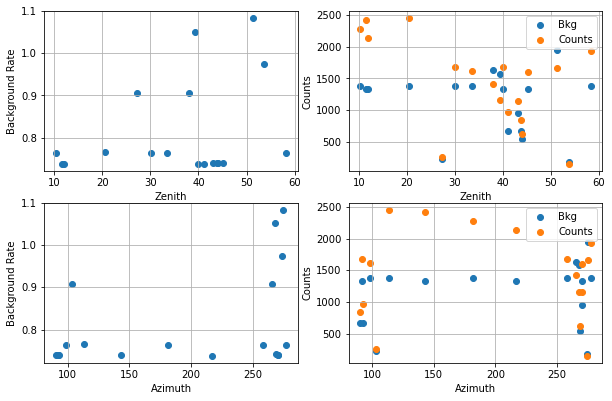

In [19]:
# Full Observations

index = -1

print(name[index])
a = complete_datasets.info_table(cumulative=False)



zen_col = []
az_col = []
for ind, obs_id in enumerate(obs_id_list):
    if obs_id in total_obs_id[index]:
        zen_col.append(list(obs_table["ZEN_PNT"])[ind])
        az_col.append(list(obs_table["AZ_PNT"])[ind])
from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate



fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()

a

In [137]:

# Joint Models: Biggest Problem is that the model is the same for all dataset independent of the zenith angle
point_model = PointSpatialModel(lon_0="83.62875 deg", lat_0="22.01236111 deg")#, evaluation_radius= "0.05 deg")
#point_model.parameters.free_parameters.freeze_all()
#point_model.lat_0.frozen = True
#point_model.lon_0.frozen = True
#point_model.lon_0.scale = 1.2
#spatial_model = point_model


spectral_model = PowerLawSpectralModel(index=2.59, amplitude=3.2e-11 * u.Unit('1 / (cm2 s TeV)'), reference=3 * u.TeV)
spectral_model.reference.frozen = False

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    apply_irf={"exposure": True, "psf": True, "edisp": True},
)


for datasets in list_of_datasets:
    for dataset in datasets:
        bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
        bkg_model.spectral_model.norm.value = 1

models = Models([model, bkg_model])

# Joint Models
for datasets in list_of_datasets:
    datasets.models = models.copy()

# Stacked Models

for stacked in list_of_stacked:
    if stacked != None:
        stacked.models = models.copy()
    
    
# Full Observations:
complete_datasets.models = models.copy()
complete_stacked.models = models.copy()

In [138]:
complete_datasets.models[0].spectral_model.index.value

2.59

In [139]:
%%time
#Model Fitting

# Joint Model
Fit_Res_Joint = []
for datasets in list_of_datasets:
    if len(datasets) != 0:
        fit_joint= Fit(datasets)
        result_joint = fit_joint.run()
        print(result_joint)
        Fit_Res_Joint.append([fit_joint, result_joint])
    else:
        Fit_Res_Joint.append(None)

# Stacked Model
Fit_Res_Stacked = []
for dataset in list_of_stacked:
    if dataset != None:
        fit_stacked= Fit(dataset)
        result_stacked = fit_stacked.run()
        print(result_stacked)
        Fit_Res_Stacked.append([fit_stacked, result_stacked])
    else:
        Fit_Res_Stacked.append(None)

        
# Full Observations:
fit_full_joint = Fit(complete_datasets)
result_full_joint = fit_full_joint.run()
print(result_full_joint)

fit_full_stacked = Fit([complete_stacked])
result_full_stacked = fit_full_stacked.run()
print(result_full_stacked)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 70
	total stat : 0.00



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 70
	total stat : 0.00



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 68
	total stat : 0.00



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 68
	total stat : 0.00



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 78
	total stat : 0.00



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 70
	total stat : 0.00



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 70
	total stat : 0.00



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 68
	total stat : 0.00



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 70
	total stat : 0.00

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 50
	total stat : 0.00



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 68
	total stat : 0.00

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 68
	total stat : 0.00

CPU times: user 23 s, sys: 439 ms, total: 23.4 s
Wall time: 28.1 s


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [140]:
# Joint
for ind in range(len(list_of_datasets)):
    if len(list_of_datasets[ind]) != 0:
        print(f"{name[ind]}")
        #print(Fit_Res_Joint[ind]) #USE Check if the fit was successful
        print(Fit_Res_Joint[ind][1].parameters.to_table())

print()
print("STACKED")
print()
# Stacked
for ind in range(len(list_of_stacked)):
    if list_of_stacked[ind] != None:
        print(f"{name[ind]}")
        #print(Fit_Res_Stacked[ind]) #USE Check if the fit was successful
        print(Fit_Res_Stacked[ind][1].parameters.to_table())
  

# Full Observations
print()
print("FULL_OBSERVATION")
print()

print(result_full_joint.parameters.to_table())
print()
print("STACKED")
print()
print(result_full_stacked.parameters.to_table())

10 to 20
   name      value         unit         min        max    frozen   error  
--------- ----------- -------------- ---------- --------- ------ ---------
    index  1.5878e+00                       nan       nan  False       nan
amplitude -6.6053e-10 cm-2 s-1 TeV-1        nan       nan  False       nan
reference  1.2453e+00            TeV        nan       nan  False       nan
    lon_0  8.3633e+01            deg        nan       nan   True 0.000e+00
    lat_0  2.2015e+01            deg -9.000e+01 9.000e+01   True 0.000e+00
20 to 30
   name      value         unit         min        max    frozen   error  
--------- ----------- -------------- ---------- --------- ------ ---------
    index  1.6026e+00                       nan       nan  False       nan
amplitude -5.2738e-10 cm-2 s-1 TeV-1        nan       nan  False       nan
reference  1.2740e+00            TeV        nan       nan  False       nan
    lon_0  8.3633e+01            deg        nan       nan   True 0.000e+00
    lat

In [120]:
# FLUX POINTS:
e_edges = MapAxis.from_energy_bounds("1 TeV", "17 TeV", nbin=15).edges
fpe = FluxPointsEstimator(energy_edges=e_edges)


# JOINT
list_of_flux_joint_datasets = []
for ind, datasets in enumerate(list_of_datasets):
    if len(datasets) != 0:
        flux_points = fpe.run(datasets=datasets)
        flux_points_datasets = FluxPointsDataset(data=flux_points, models=datasets.models)
        list_of_flux_joint_datasets.append(flux_points_datasets)
    else:
        list_of_flux_joint_datasets.append(None)



# STACKED
list_of_flux_stacked_datasets = []
for ind, stacked in enumerate(list_of_stacked):
    if stacked != None:
        flux_points = fpe.run(datasets=[stacked])
        flux_points_stacked = FluxPointsDataset(data=flux_points, models=stacked.models)
        list_of_flux_stacked_datasets.append(flux_points_stacked)
    else:
        list_of_flux_stacked_datasets.append(None)

# Full (Stacked Only)

flux_points = fpe.run(datasets=[complete_stacked])
flux_points_full_stacked = FluxPointsDataset(data=flux_points, models=complete_stacked.models)

In [121]:
# TO see the threshold...

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-

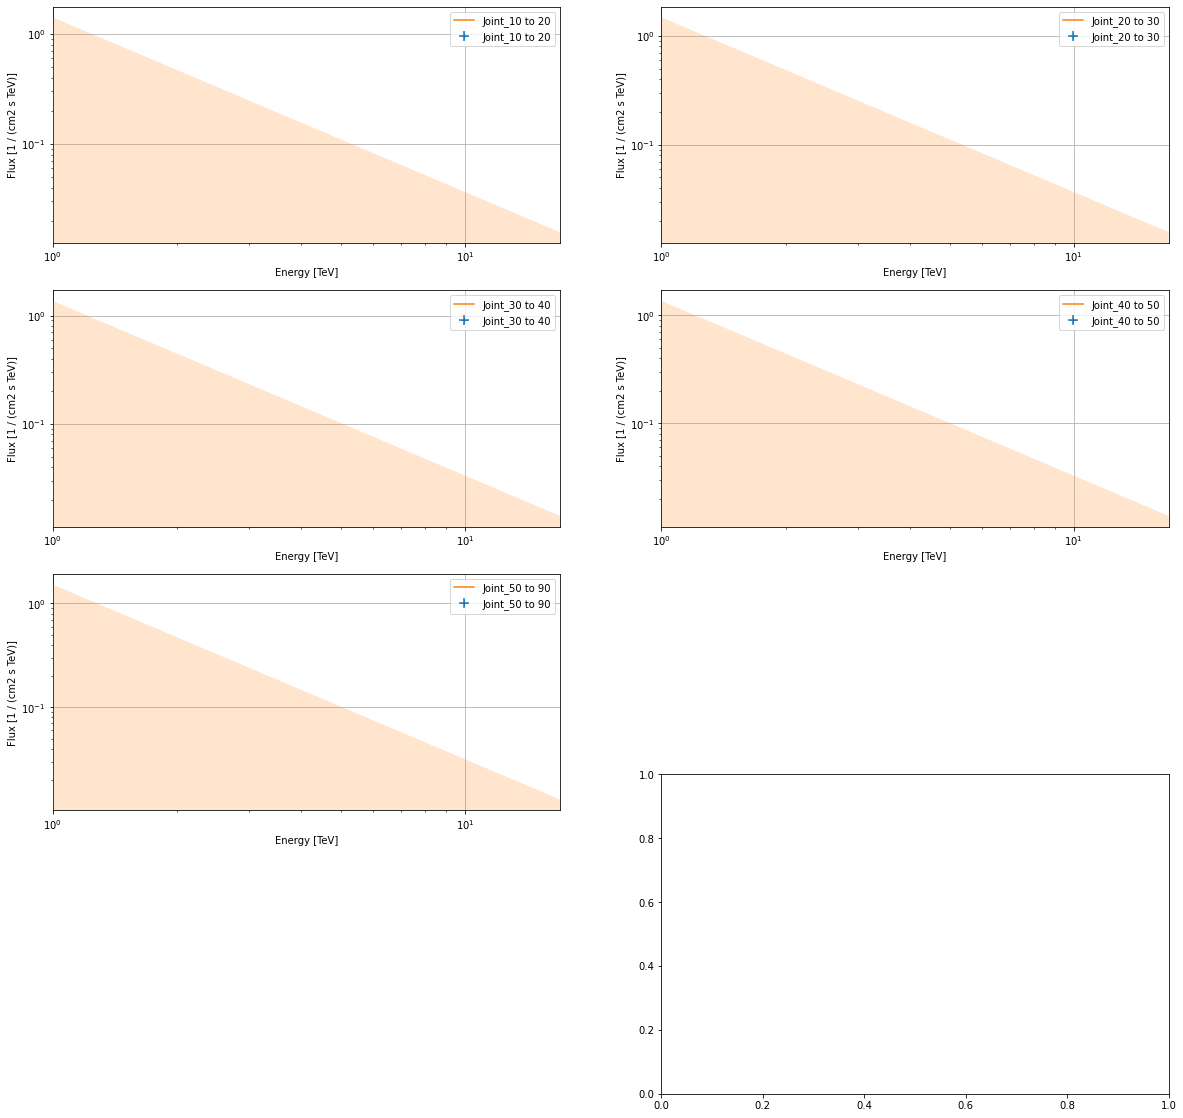

In [122]:
# JOINT SPECTRUM. We can see the increase in energy threshold. Basically, if you look at the first few points, you see that they occur further from each other as the zenith increses.

count = 1 # number of plot
for datasets in list_of_flux_joint_datasets:
    if datasets != None:
        count +=1

fig, axs = plt.subplots(count-3,2, figsize = (20, 20))

c = 1
for ind, datasets in enumerate(list_of_flux_joint_datasets):
    if datasets != None:
        plt.subplot(count-2, 2, c)
        datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Joint_{name[ind]}");
        plt.legend()
        plt.grid()
        c += 1

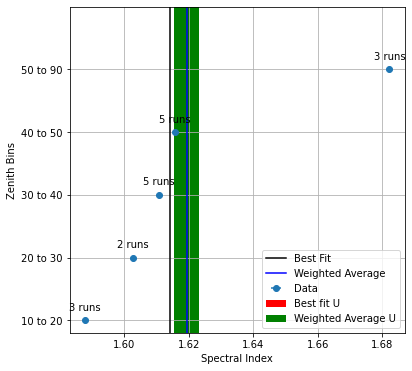

In [123]:
plt.figure(figsize=(6,6))
num_obs = [3, 2, 5, 5, 3]
index_list = []
name_list = []
index_error = []
for ind, datasets in enumerate(list_of_flux_joint_datasets):
    #print(datasets)
    if datasets != None:
        name_list.append(name[ind])
        index_list.append(datasets.models[0].spectral_model.index.value)
        index_error.append(datasets.models[0].spectral_model.index.error)


plt.errorbar(x=index_list, y=name_list, xerr=index_error, fmt="o", label="Data")
# Best Fit
plt.bar(x = complete_datasets.models[0].spectral_model.index.value, width=complete_datasets.models[0].spectral_model.index.error, height = (-2, 5), color="red", label="Best fit U")
plt.axvline(x = complete_datasets.models[0].spectral_model.index.value, ymin = -2, ymax = 5, color="black", label="Best Fit")
#plt.axvline(x=2.37,ymax = 5, color="orange", label="Best Fit")
    
weighted_avg = np.average(index_list, weights =num_obs)   
# Uncertainty:
num = 0

for [d, w] in zip(index_list, num_obs):
    num += w*(d-weighted_avg)**2

avg_err = 1/np.sqrt(18) *np.sqrt(num/(((len(num_obs)-1)/(len(num_obs)))*sum(num_obs)))

plt.bar(x = weighted_avg, width = avg_err, height = (-2, 5), color="green", label="Weighted Average U")
plt.axvline(x = weighted_avg, ymin = -2, ymax = 5, color="blue", label="Weighted Average")
count = 0 
for [x, y] in zip(index_list, name_list):
    label = f"{num_obs[count]} runs".format(y)
    count += 1
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 

plt.ylim([-0.2, 5])
plt.xlabel("Spectral Index")
plt.ylabel("Zenith Bins")
plt.legend()
plt.grid()

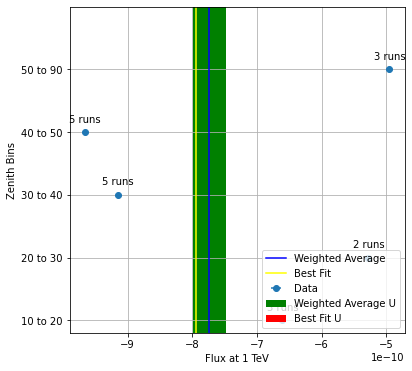

In [124]:
plt.figure(figsize=(6,6))
num_obs = [3, 2, 5, 5, 3]
amplitude_list = []
name_list = []
amplitude_error = []
for ind, datasets in enumerate(list_of_flux_joint_datasets):
    if datasets != None:
        name_list.append(name[ind])
        amplitude_list.append(datasets.models[0].spectral_model.amplitude.value)
        amplitude_error.append(datasets.models[0].spectral_model.amplitude.error)


plt.errorbar(x=amplitude_list, y=name_list, xerr=amplitude_error, fmt="o", label="Data")
# Best Fit

weighted_avg = np.average(amplitude_list, weights =num_obs)   
# Uncertainty:
num = 0

for [d, w] in zip(amplitude_list, num_obs):
    num += w*(d-weighted_avg)**2

avg_err = 1/np.sqrt(18) *np.sqrt(num/(((len(num_obs)-1)/(len(num_obs)))*sum(num_obs)))

plt.bar(x = weighted_avg, width = avg_err, height = (-2, 5), color="green", label="Weighted Average U")
plt.axvline(x = weighted_avg, ymin = -2, ymax = 5, color="blue", label="Weighted Average")

plt.axvline(x = complete_datasets.models[0].spectral_model.amplitude.value, ymin = -2, ymax = 5, color="yellow", label="Best Fit")
plt.bar(x = complete_datasets.models[0].spectral_model.amplitude.value, width=complete_datasets.models[0].spectral_model.amplitude.error, height = (-2, 5), color="red", label="Best Fit U")
count = 0 
for [x, y] in zip(amplitude_list, name_list):
    label = f"{num_obs[count]} runs".format(y)
    count += 1
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 

plt.ylim([-0.2, 5])
plt.xlabel("Flux at 1 TeV")
plt.ylabel("Zenith Bins")
plt.legend(loc="lower right")
plt.grid()

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/modeling/models/spectral.py:406: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")


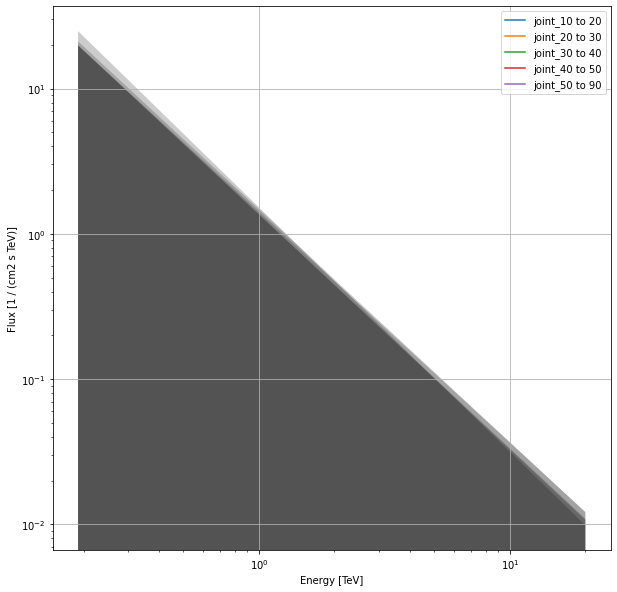

In [125]:

def plot_spectrum(model, result, label):
    spec = model.spectral_model
    energy_range = [0.19, 20] * u.TeV
    spec.plot(
        energy_range=energy_range, energy_power=0, label=label
    )
    spec.plot_error(energy_range=energy_range, energy_power=0)

plt.figure(figsize = (10, 10))
for ind, datasets in enumerate(list_of_flux_joint_datasets):
    if datasets != None:
        #datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Joint_{name[ind]}");
        plot_spectrum(datasets.models[0], Fit_Res_Joint[ind][1], f"joint_{name[ind]}")
        plt.legend()
        plt.grid()


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-

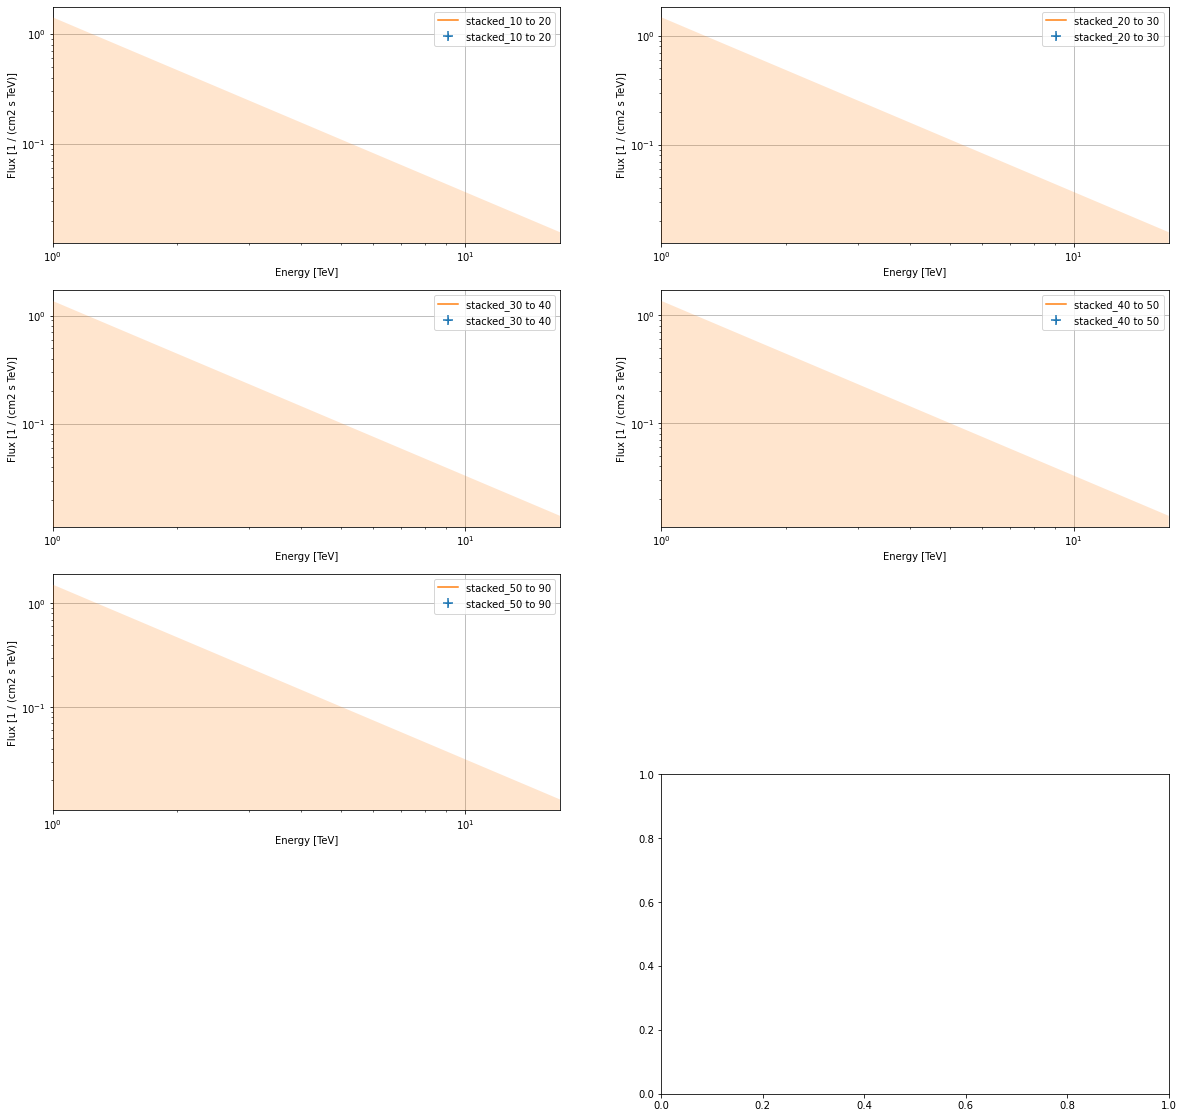

In [126]:
# Stacked SPECTRUM

count = 1 # number of plot
for stacked in list_of_flux_stacked_datasets:
    if stacked != None:
        count +=1

fig, axs = plt.subplots(count-3,2, figsize = (20, 20))
c = 1
for ind, stacked in enumerate(list_of_flux_stacked_datasets):
    if stacked != None:
        plt.subplot(count-2, 2, c)
        stacked.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"stacked_{name[ind]}");
        plt.legend()
        plt.grid()
        c += 1


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/modeling/models/spectral.py:406: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")


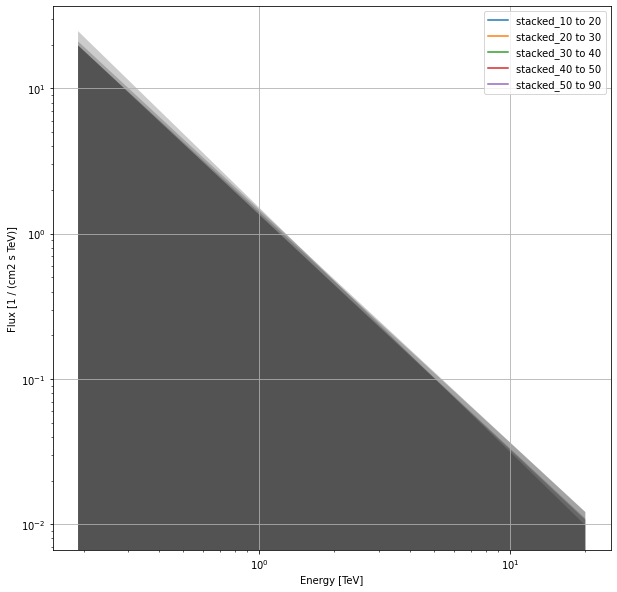

In [127]:
plt.figure(figsize=(10,10))
for ind, datasets in enumerate(list_of_flux_stacked_datasets):
    if datasets != None:
        #datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Stacked_{name[ind]}");
        plot_spectrum(datasets.models[0], Fit_Res_Stacked[ind][1], f"stacked_{name[ind]}")
        plt.legend()
        plt.grid()

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")


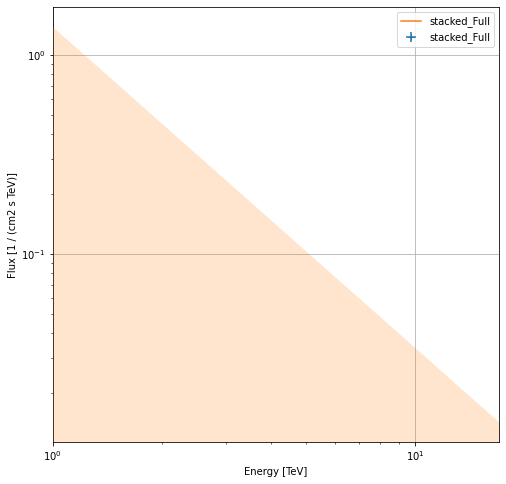

In [128]:
# Full observations
plt.figure(figsize = (8, 8))
flux_points_full_stacked.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"stacked_{name[-1]}");
plt.legend()
plt.grid()


In [129]:
# FLUX POINTS:
e_edges = MapAxis.from_energy_bounds("1 TeV", "12.589 TeV", nbin=15).edges
fpe = FluxPointsEstimator(energy_edges=e_edges)


# JOINT
list_of_flux_joint_datasets = []
for ind, datasets in enumerate(list_of_datasets):
    if len(datasets) != 0:
        flux_points = fpe.run(datasets=datasets)
        flux_points_datasets = FluxPointsDataset(data=flux_points, models=datasets.models)
        list_of_flux_joint_datasets.append(flux_points_datasets)
    else:
        list_of_flux_joint_datasets.append(None)



# STACKED
list_of_flux_stacked_datasets = []
for ind, stacked in enumerate(list_of_stacked):
    if stacked != None:
        flux_points = fpe.run(datasets=[stacked])
        flux_points_stacked = FluxPointsDataset(data=flux_points, models=stacked.models)
        list_of_flux_stacked_datasets.append(flux_points_stacked)
    else:
        list_of_flux_stacked_datasets.append(None)

# Full (Stacked Only)

flux_points = fpe.run(datasets=[complete_stacked])
flux_points_full_stacked = FluxPointsDataset(data=flux_points, models=complete_stacked.models)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-

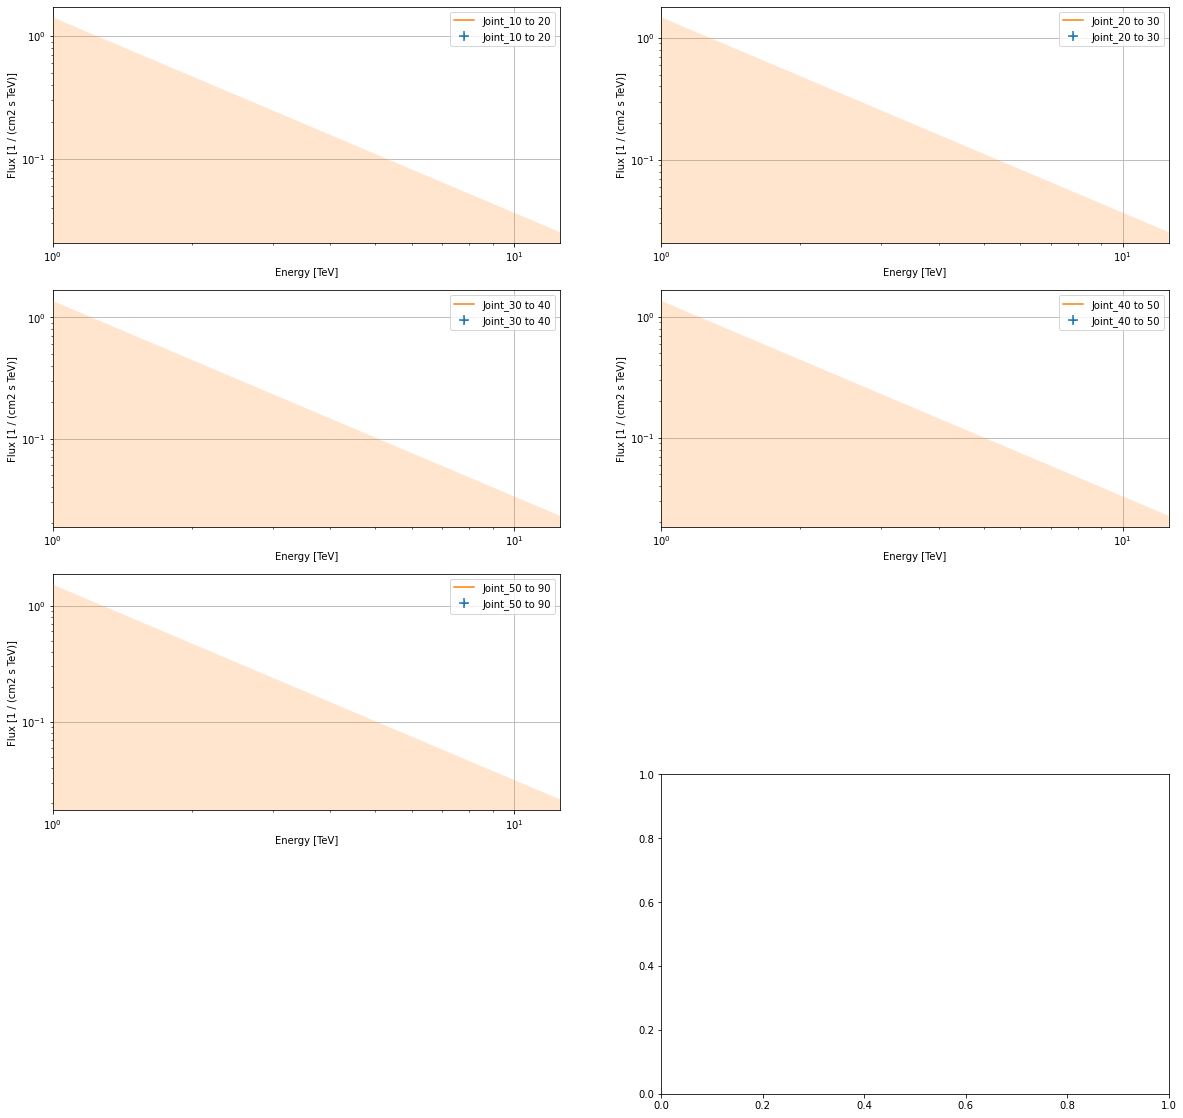

In [130]:

count = 1 # number of plot
for datasets in list_of_flux_joint_datasets:
    if datasets != None:
        count +=1

fig, axs = plt.subplots(count-3,2, figsize = (20, 20))

c = 1
for ind, datasets in enumerate(list_of_flux_joint_datasets):
    if datasets != None:
        plt.subplot(count-2, 2, c)
        datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Joint_{name[ind]}");
        plt.legend()
        plt.grid()
        c += 1

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/modeling/models/spectral.py:406: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")


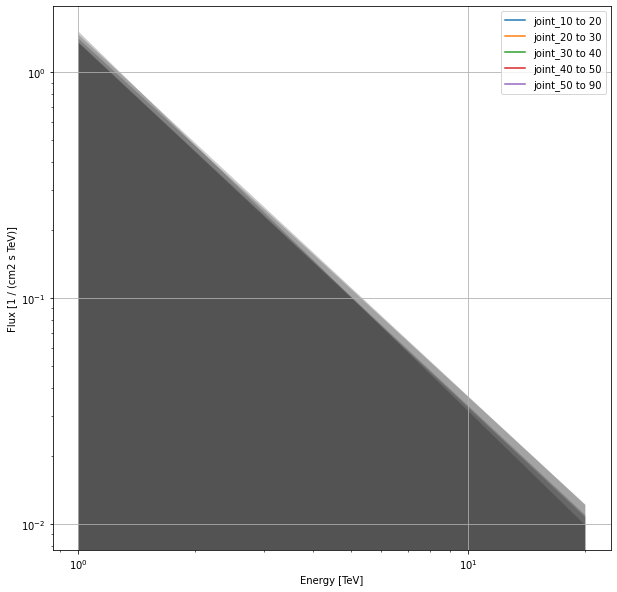

In [131]:
def plot_spectrum(model, result, label):
    spec = model.spectral_model
    energy_range = [1, 20] * u.TeV
    spec.plot(
        energy_range=energy_range, energy_power=0, label=label
    )
    spec.plot_error(energy_range=energy_range, energy_power=0)

plt.figure(figsize = (10, 10))
for ind, datasets in enumerate(list_of_flux_joint_datasets):
    if datasets != None:
        #datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Joint_{name[ind]}");
        plot_spectrum(datasets.models[0], Fit_Res_Joint[ind][1], f"joint_{name[ind]}")
        plt.legend()
        plt.grid()

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")
/Users/cedrickperron/opt/anaconda3/envs/gammapy-

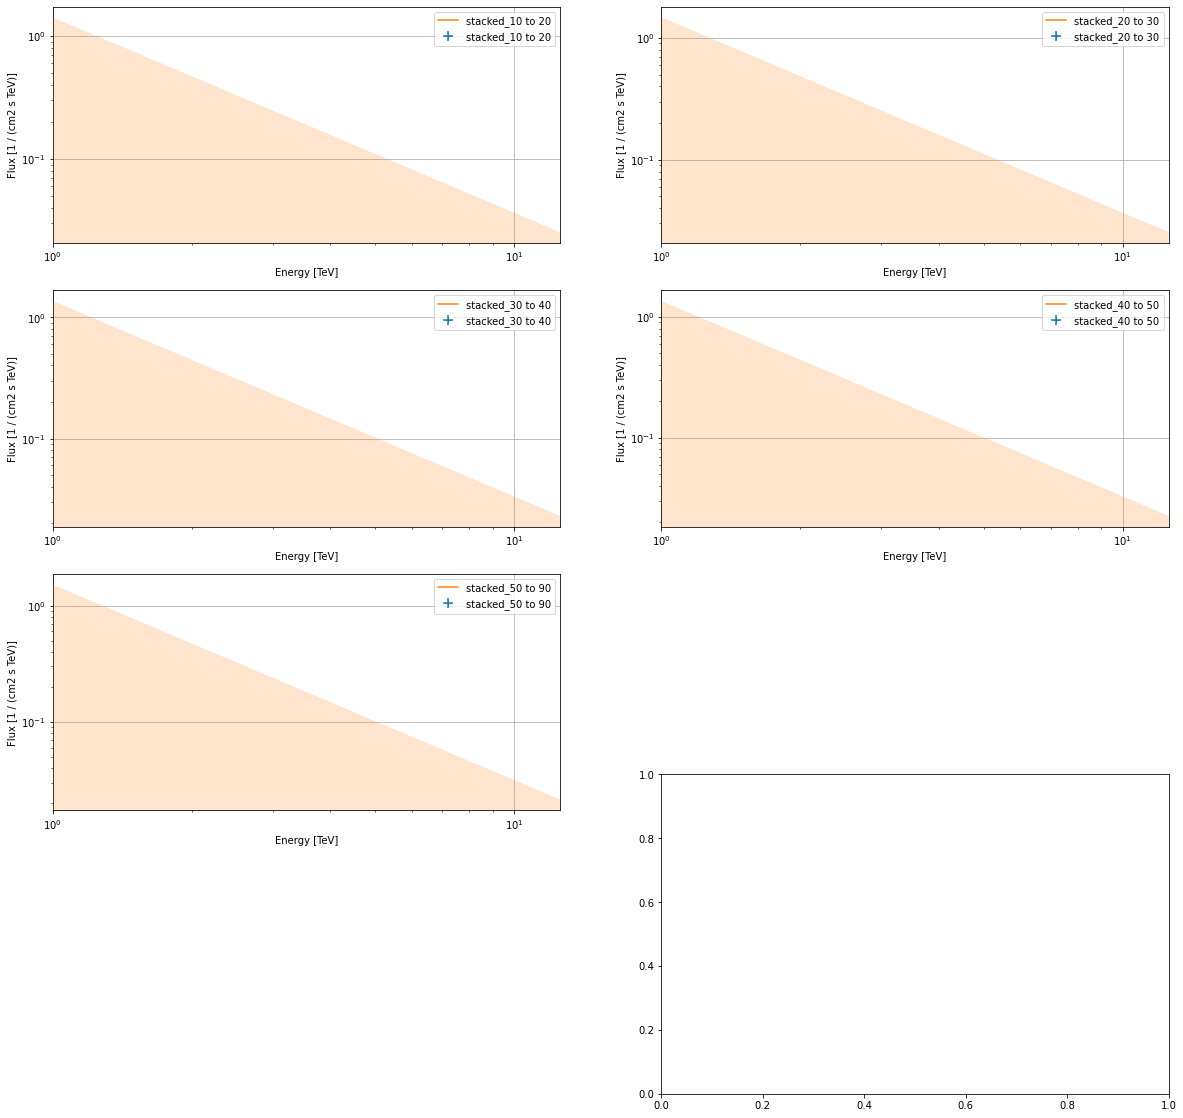

In [132]:
# Stacked SPECTRUM

count = 1 # number of plot
for stacked in list_of_flux_stacked_datasets:
    if stacked != None:
        count +=1

fig, axs = plt.subplots(count-3,2, figsize = (20, 20))
c = 1
for ind, stacked in enumerate(list_of_flux_stacked_datasets):
    if stacked != None:
        plt.subplot(count-2, 2, c)
        stacked.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"stacked_{name[ind]}");
        plt.legend()
        plt.grid()
        c += 1

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/modeling/models/spectral.py:406: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonposy="clip")


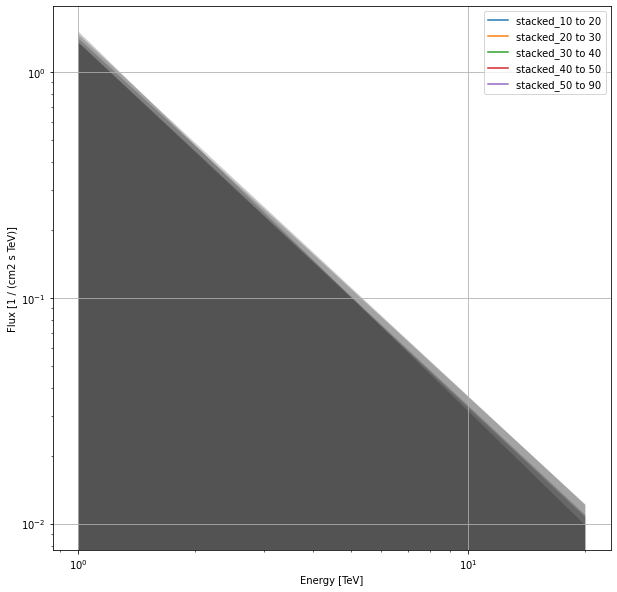

In [133]:
plt.figure(figsize=(10,10))
for ind, datasets in enumerate(list_of_flux_stacked_datasets):
    if datasets != None:
        #datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Stacked_{name[ind]}");
        plot_spectrum(datasets.models[0], Fit_Res_Stacked[ind][1], f"stacked_{name[ind]}")
        plt.legend()
        plt.grid()

time_min,time_max,counts [1],e_ref [1],e_min [1],e_max [1],ref_dnde [1],ref_flux [1],ref_eflux [1],ref_e2dnde [1],norm [1],stat [1],success [1],norm_err [1],ts [1],norm_errp [1],norm_errn [1],norm_ul [1],"norm_scan [1,11]","stat_scan [1,11]",sqrt_ts [1],dnde [1],dnde_ul [1],dnde_err [1],dnde_errp [1],dnde_errn [1],flux [1],flux_ul [1],flux_err [1],flux_errp [1],flux_errn [1]
,,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
59217.174861346255,59217.17774059017,7.0,4.123105625617661,1.0,17.0,-1.120361161294405e-10,-1.4803156525250827e-09,-5.668714612429306e-09,-1.9046139742004883e-09,1.0,0.0,False,0.16125613239491807,76.91261131291476,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,0.0 .. 0.0,8.769983541199764,-1.120361161294405e-10,nan,-1.806651077558147e-11,nan,nan,-1.4803156525250827e-09,nan,-2.387099768498543e-10,nan,nan
59218.122922211616,59218.133375946956,24.0,4.123105625617661,1.0,17.0,-1.120361161294405e-10,-1.4803156525250827e-09,-5.668714612429306e-09,-1.9046139742004883e-09,1.0,0.0,False,0.11327854933075569,155.8600055405103,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,0.0 .. 0.0,12.484390475329995,-1.120361161294405e-10,nan,-1.2691288707795099e-11,nan,nan,-1.4803156525250827e-09,nan,-1.676880096696524e-10,nan,nan
59222.10389424122,59222.11431434741,25.0,4.123105625617661,1.0,17.0,-1.120361161294405e-10,-1.4803156525250827e-09,-5.668714612429306e-09,-1.9046139742004883e-09,1.0,0.0,False,0.11096409688418435,162.42956240721537,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,0.0 .. 0.0,12.744785694832823,-1.120361161294405e-10,nan,-1.2431986444714964e-11,nan,nan,-1.4803156525250827e-09,nan,-1.6426188948596784e-10,nan,nan
59224.103883063704,59224.1247195057,54.0,4.123105625617661,1.0,17.0,-1.120361161294405e-10,-1.4803156525250827e-09,-5.668714612429306e-09,-1.9046139742004883e-09,1.0,0.0,False,0.09123224683836441,240.2886824837872,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,0.0 .. 0.0,15.501247771833956,-1.120361161294405e-10,nan,-1.0221306601532775e-11,nan,nan,-1.4803156525250827e-09,nan,-1.3505252300986281e-10,nan,nan
59224.1254114728,59224.1462481309,45.0,4.123105625617661,1.0,17.0,-1.120361161294405e-10,-1.4803156525250827e-09,-5.668714612429306e-09,-1.9046139742004883e-09,1.0,0.0,False,0.08639660985708171,267.93947251092266,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,0.0 .. 0.0,16.368856786926894,-1.120361161294405e-10,nan,-9.67954061513797e-12,nan,nan,-1.4803156525250827e-09,nan,-1.278942538965409e-10,nan,nan
59224.16833461763,59224.18917175426,30.0,4.123105625617661,1.0,17.0,-1.120361161294405e-10,-1.4803156525250827e-09,-5.668714612429306e-09,-1.9046139742004883e-09,1.0,0.0,False,0.10381855455637845,185.55817134012804,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,0.0 .. 0.0,13.621973841559381,-1.120361161294405e-10,nan,-1.163142763466907e-11,nan,nan,-1.4803156525250827e-09,nan,-1.5368423133233628e-10,nan,nan
59224.20485552736,59224.22569260486,38.0,4.123105625617661,1.0,17.0,-1.120361161294405e-10,-1.4803156525250827e-09,-5.668714612429306e-09,-1.9046139742004883e-09,1.0,0.0,False,0.085288615778352,274.94633571432945,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,0.0 .. 0.0,16.58150583373927,-1.120361161294405e-10,nan,-9.555405261862676e-12,nan,nan,-1.4803156525250827e-09,nan,-1.2625407291889222e-10,nan,nan
59224.2263527344,59224.2471896905,44.0,4.123105625617661,1.0,17.0,-1.120361161294405e-10,-1.4803156525250827e-09,-5.668714612429306e-09,-1.9046139742004883e-09,1.0,0.0,False,0.07895394423749089,320.83549228170347,nan,nan,nan,0.20000000000000004 .. 5.0

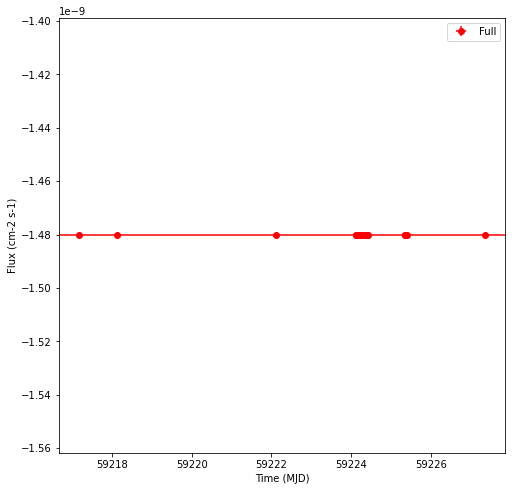

In [134]:
#Full Observations



lc_maker_1d = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], reoptimize=True)
lc_complete = lc_maker_1d.run(complete_datasets)

plt.figure(figsize=(8,8))
ax = lc_complete.plot(marker="o", color="red", label=f"{name[-1]}")
plt.axhline(y=lc_complete.table["flux"].mean(), color="red", label="Mean Flux Line Gam")

lc_complete.table

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()
No handles with labels found to put in legend.


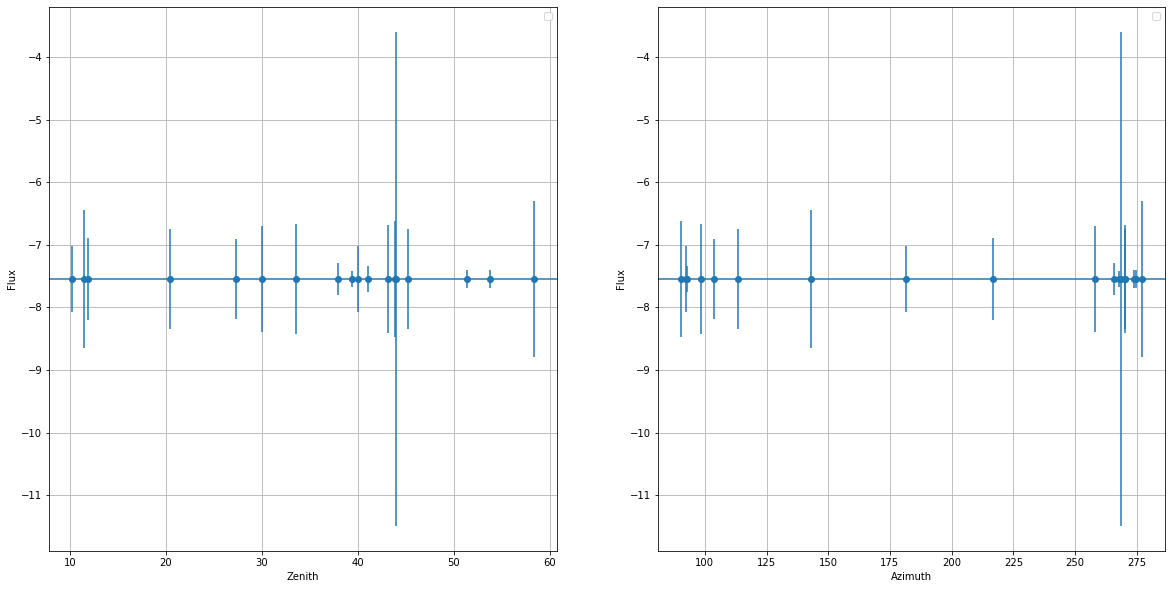

In [84]:



plt.figure(figsize=(20,10))
plt.subplot(1, 2,1)
plt.errorbar(x=list(obs_table["ZEN_PNT"]),y=list(lc_complete.table["flux"]), yerr=list(lc_complete.table["flux_err"]), fmt="o")
plt.axhline(y=lc_complete.table["flux"].mean(), color="tab:blue")
plt.xlabel("Zenith")
plt.ylabel("Flux")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.errorbar(x=list(obs_table["AZ_PNT"]),y=list(lc_complete.table["flux"]), yerr=list(lc_complete.table["flux_err"]), fmt="o")
plt.axhline(y=lc_complete.table["flux"].mean(), color="tab:blue")
plt.xlabel("Azimuth")
plt.ylabel("Flux")
plt.legend()
plt.grid()


In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection="3d")


ax.scatter(list(obs_table["ZEN_PNT"]), list(obs_table["AZ_PNT"]), list(lc_complete.table["flux"]),  zdir='z', s=20, c=None, depthshade=True)
plt.show()

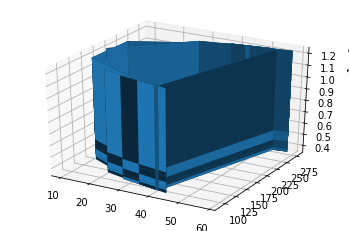

In [47]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(np.array(obs_table["ZEN_PNT"]), np.array(obs_table["AZ_PNT"]), np.array(lc_complete.table["flux"]))
plt.show()

In [48]:
list_spectrum_datasets = Datasets()


joint_stacked = SpectrumDataset.create(e_reco=energy_axis, e_true=energy_axis_true, region=on_region, name="Spectrum_stacked")

for dataset in complete_datasets:
    spectrum_dataset = dataset.to_spectrum_dataset(on_region=on_region, containment_correction=True, name = dataset.name)
    joint_stacked.stack(spectrum_dataset)
    list_spectrum_datasets.append(spectrum_dataset)

stack_stacked = complete_stacked.to_spectrum_dataset(on_region=on_region, containment_correction=True, name = dataset.name)
    

In [49]:
print("STACKED STACK")
print(stack_stacked)
print(stack_stacked.info_dict())
print()
print("JOINT_STACKED")
print(joint_stacked)
print(joint_stacked.info_dict())

STACKED STACK
SpectrumDataset
---------------

  Name                            : 97487_Full 

  Total counts                    : 1687 
  Total background counts         : 71.31
  Total excess counts             : 1615.69

  Predicted counts                : 71.31
  Predicted background counts     : 71.31
  Predicted excess counts         : nan

  Exposure min                    : 1.44e+05 m2 s
  Exposure max                    : 5.41e+09 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


{'name': '97487_Full', 'counts': 1687.0, 'background': 71.30811, 'excess': 1615.6919, 'sqrt_ts': 86.27241271741599, 'npred': 71.30810175836086, 'npred_background': 71.30811, 'npred_signal': nan, 'exposure_min': <Quantity 143982.88 m2 s>, 'exposure_max': <Quantity 5.411

In [60]:
Table(list_spectrum_datasets.info_table(cumulative=True)[-1]["counts", "background", "excess", "sqrt_ts", "ontime", "counts_rate", "background_rate","excess_rate"])

counts,background,excess,sqrt_ts,ontime,counts_rate,background_rate,excess_rate
,,,,s,1 / s,1 / s,1 / s
float32,float64,float64,float64,float64,float64,float64,float64
1687.0,65.19955225973179,1621.8004477402683,87.93679039183522,25565.114946246147,0.06598835966695743,0.002550332842110118,0.06343802682484732
